# MalURL Detector
---

**Authors:** Alistair Gillespie and Veatrissa Lim

### Introduction
Here lies a classification model that aims to predict the maliciousnes of any given URL. The notebook is a collection of data cleaning, feature engineering and modelling steps, that combine to deliver the MalURL Detector. The model is based on a set of reputational and lexical features. Currently, the MalURL detector uses an ensemble of decision trees (i.e. a random forest)

**Status**: 19/05/2019 - Currently working on additional features and model tuning. In addition, to sourcing new training data.




| Sections              | Description   |
| :---------------------|:---------------|
| Introduction         | Introduction to the MalURL Detector |
| Setup                | Import foundational and machine learning libraries |
| Data Ingestion       | Ingest and clean the URL and IANA data sets    |
| Feature Engineering  | Extract and engineer the set of reputational and lexical features|
| Modeling             | Train and tune the Random Forest classifier, then make some predictions |


Next steps:
* Consider new reputational features i.e. last updated
* Use binary encoding for categorical features rather than Label Encoder
* Conduct further model tuning and deepen understanding of Random Forest and other candidate classifiers
* Handling of unseen values in test phase i.e. categorical features and encodings
* More to come...

### Setup

In [1]:
# GENERAL
import os
import math
import re
import datetime
import time
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
import seaborn as sns

# SKLEARN
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, f1_score ,recall_score, accuracy_score, precision_score, confusion_matrix
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

# DOMAIN SPECIFIC LIBRARIES
import tldextract
from datetime import datetime
import warnings
from urllib.parse import urlparse
from socket import gethostbyname, gaierror
import whois

# iPython and Notebook config
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" #display all results
%config InlineBackend.figure_format = 'retina' #see plots in retina displays
%matplotlib inline

### Setup utilities for feature extraction

In [2]:
def creation_date(domain_name):
    """
    Gets creation date of domain
    """
    
    # Get creation date of Domain 
    domain_name = whois.whois(domain_name).creation_date
    
    # Handling exceptions
    if type(domain_name) is list:
        return domain_name[0]
    elif str(domain_name).find('Aug'):
        domain_name = "1996-07-01 00:00:01"
        return domain_name
    elif domain_name == np.nan:
        currentDT = datetime.now()
        domain_name = currentDT.strftime("%Y-%m-%d %H:%M:%S")
        return domain_name
    else:
        return domain_name

In [3]:
def countSpecial(x):
    """
    Counts number of special characters in a string
    """
    new = re.sub('[\w]+' ,'', x)
    return len(new)

In [4]:
def entropy(string):
    """
    Calculates the Shannon entropy of a string
    """

    # Get probability of chars in string
    prob = [ float(string.count(c)) / len(string) for c in dict.fromkeys(list(string)) ]

    # Calculate the entropy
    entropy = - sum([ p * math.log(p) / math.log(2.0) for p in prob ])

    return entropy

In [5]:
def host_ip(domain):
    """
    Gets Host IP of Domain
    """

    # Get HOST IP     
    try:
        host = gethostbyname(domain)
        return host
    except gaierror:
        return 'missing'

### Setup feature extraction functions

In [6]:
def get_domain_parts(df, feature_col):
    """
    Extract domain components
    """
    
    # Extract domain
    df['domain'] = df[feature_col].apply(lambda x: tldextract.extract(x).domain)
    
    # Extract suffix
    df['suffix'] = df[feature_col].apply(lambda x: tldextract.extract(x).suffix)
    
    # Extract suffix
    df['domain_name'] = df[feature_col].apply(lambda x: tldextract.extract(x).registered_domain)
    
    # TODO - Handle null domain and suffix
    
    return df

In [7]:
def get_host_ip(df, domain_col):
    """
    Gets host IP address associated with domain
    """
    
    # Extract Host IP 
    df['host_ip'] = df[domain_col].apply(lambda x: host_ip(x))
    
    # TODO - Handle null hosts
    
    return df

In [8]:
def get_prefix(df, host_col):
    """
    Gets first octet of IP
    """
    
    # Extract prefix, first octet
    df['prefix'] = df[host_col].str.extract('(\d+)\.').astype(int, errors='ignore').astype(str)
    df['prefix'] = df['prefix'].fillna('missing')
    df['prefix'] = df['prefix'].replace('nan', 'missing')
    
    return df   

In [9]:
def get_creation_date(df, feature_col):
    """
    Gets creation date of domain
    """
    
    df['domain_creation'] = df[feature_col].apply(lambda x: creation_date(x))

    return df

In [10]:
def get_domain_age(df, creation_col):
    """
    Calculates the age of the domain in days
    """
      
    # Cast domain age columnt to datetime
    df[creation_col] = pd.to_datetime(df[creation_col], format='%Y-%m-%d %H:%M:%S')
    
    # Calculate the age of the domain
    df['domain_age'] = pd.datetime.today().date() - df[creation_col].dt.date
    
    # Cast age to an integer
    df['domain_age'] = df['domain_age'].astype(str).str.extract("(\d+)").astype(float)

    return df

In [11]:
def get_domain_entropy(df, feature_col):
    """
    Calculates entropy of a feature for a given data set
    """
    
    # Calculate entropy 
    df['entropy'] = df[feature_col].apply(lambda x: entropy(str(x)))

    return df

In [12]:
def get_number_suffix(df, feature_col):
    """
    Calculates number of suffix in the URL
    """
    
    # Calculates number of suffix in the URL
    df['number_suffix'] = df[feature_col].str.count('\.')
    
    return df

In [13]:
def get_number_digits(df, feature_col):
    """
    Calculates number of numerical characters in a string
    """
    
    # Calculates number of digits
    df['number_digits'] = df[feature_col].str.count('[0-9]')
    
    return df

In [14]:
def get_percent_digits(df):
    """
    Calculates percentage of string is a digit
    """
    
    # Calculate percentage
    df['digits_percentage'] = (df['number_digits']/df['string_length'])*100
    
    return df

In [15]:
def get_string_length(df, feature_col):
    """
    Calculates length of string
    """

    # Calculates length of string
    df['string_length'] = df[feature_col].str.len()
    
    return df

In [16]:
def get_specials(df, feature_col):
    """
    Calculates number of special characters in string
    """
    
    # Count of special characters
    df['specials'] = df[feature_col].apply(lambda x: countSpecial(str(x)))
   
    return df

In [17]:
def get_iana_designations(df, iana, prefix_col):
    """
    Merges data sets on the prefix i.e. first octect of the IPv4 address
    """

    # Enrich sample with IPv4 Registry data
    df = df.merge(iana, on=prefix_col, how='left')

    # Clean prefix and drop unneeded columns
    df['prefix'] = df['prefix'].astype(str)
    df['designation'] = df['designation'].fillna('missing')
    df.rename(columns={ 'status [1]': 'status'}, inplace=True)
    df.drop(['note'], axis=1, inplace=True)

    return df

In [18]:
def feature_extraction_train(data, iana_data):
    """
    Pipeline utility for extracting all candidate functions
    """
    
    # Assumes string or dataframe input
    
    # Handle string or dataframe input
    if not isinstance(data, pd.DataFrame):
        df = pd.DataFrame(data=[data], columns=['url']) # Create dataframe from string  
    else:
        df = data
    
    # Conduct extraction
    print('  * Loading features')
    df = get_domain_entropy(df, 'domain_name') # Extract domain entropy
    df[df['domain_creation'] == str]
    df = get_domain_age(df, 'domain_creation') # Extract domain age
    df = get_number_suffix(df, 'domain_name') # Extract number of suffix
    df = get_number_digits(df, 'domain_name') # Extract number of digits
    df = get_string_length(df, 'domain_name') # Extract string length
    df = get_percent_digits(df) # Extract percentage digits
    df = get_specials(df, 'domain_name') # Extract number of specials
    df = get_iana_designations(df, iana_data,'prefix') # Extract designation
    
    print('  * Number of features extracted: ' + str(len(df.columns.tolist())))
    
    return df

In [19]:
def feature_extraction_prod(data, iana_data):
    """
    Pipeline utility for extracting all candidate functions
    """
    
    # Assumes string or dataframe input
    
    # Handle string or dataframe input
    if not isinstance(data, pd.DataFrame):
        df = pd.DataFrame(data=[data], columns=['url']) # Create dataframe from string  
    else:
        df = data
    
    # Conduct extraction
    print('  * Loading features')
    df = get_domain_parts(df, 'url') # Extract domain parts
    df = get_creation_date(df, 'domain_name') # Extract domain creation date
    df = get_domain_age(df, 'domain_creation') # Extract domain age
    df = get_domain_entropy(df, 'domain_name') # Extract domain entropy       
    df = get_number_suffix(df, 'domain_name') # Extract number of suffix
    df = get_number_digits(df, 'domain_name') # Extract number of digits
    df = get_string_length(df, 'domain_name') # Extract string length
    df = get_percent_digits(df) # Extract percentage digits
    df = get_specials(df, 'domain_name') # Extract number of specials
    df = get_host_ip(df, 'domain_name') # Extract host IP
    df = get_prefix(df, 'host_ip') # Extract prefix
    df = get_iana_designations(df, iana_data,'prefix') # Extract designation
    
    print('  * Number of features extracted: ' + str(len(df.columns.tolist())))
    
    return df

In [20]:
def feature_engineering_train(df): 
    """
    Conduct encoding, normalisation and standardisation of features
    """
    
    # Setup Label Encoders
    suffix_le = LabelEncoder()
    designation_le = LabelEncoder()
    prefix_le = LabelEncoder()

    # Fit labels and transform data
    df['suffix'] = suffix_le.fit_transform(df['suffix'])
    df['designation'] = designation_le.fit_transform(df['designation'])
    df['prefix'] = prefix_le.fit_transform(df['prefix'])
    
    # Save encodings
    np.save('suffix.npy', suffix_le.classes_)
    np.save('designation.npy', designation_le.classes_)
    np.save('prefix.npy', prefix_le.classes_)
    
    # Setup min max scaler for dense variables
    mms = MinMaxScaler()
    
    # Fit distributions and transform data
    df[['entropy', 'domain_age']] = mms.fit_transform(df[['entropy', 'domain_age']])
    
    # Save Min Max models
    joblib.dump(mms, 'mms.pkl')
    
    # Setup Max Abs scaler for sparse variables
    mas = MaxAbsScaler()
    
    # Fit distributions and transform data
    num_features = ['number_digits', 'string_length','digits_percentage', 
                    'specials', 'number_suffix']
    df[num_features] = mas.fit_transform(df[num_features])
    
    # Save Max Abs models
    joblib.dump(mas, 'mas.pkl')
    
    return df

In [21]:
  def feature_engineering_prod(df): 
    """
    Conduct encoding, normalisation and standardisation of features
    """
    
    # Setup Label Encoders
    suffix_le = LabelEncoder()
    designation_le = LabelEncoder()
    prefix_le = LabelEncoder()
    
    # Load encodings
    suffix_le.classes_ = np.load('suffix.npy', allow_pickle=True)
    designation_le.classes_ = np.load('designation.npy', allow_pickle=True)
    prefix_le.classes_ = np.load('prefix.npy', allow_pickle=True)
    
    # Get integer mappings
    integer_mapping = {l: i for i, l in enumerate(prefix_le.classes_)}
    
    # Transform categorical variables
    # If prefix exists already, then transform
    if df['prefix'].isin(integer_mapping).any():
        # If value is in mapping list, transform
        prefix_le.transform(df[['prefix']])
        print('  * Value successfully transformed.') 
    
    # Else value is not in mapping list, add to mapping list and transform
    else:
        prefix_le.classes_ = np.append(prefix_le.classes_, df['prefix'].iloc[0:1])
        prefix_le.transform(df.prefix)
        print('  * New unseen value added to label encoder.')

    df[['suffix']] = suffix_le.transform(df[['suffix']])
    df[['designation']] = designation_le.transform(df[['designation']])
    
    # Load MinMax models
    mms = joblib.load('mms.pkl')
    
    # Transform min max features
    df[['entropy', 'domain_age']] = mms.transform(df[['entropy', 'domain_age']])
    
    # Load Max Abs models
    mas =joblib.load('mas.pkl')
    
    num_features = ['number_digits', 'string_length','digits_percentage', 
                    'specials', 'number_suffix']
    
    # Transform Max Abs features
    df[num_features] = mas.transform(df[num_features])
    
    return df

In [29]:
def train_model(df, features, test_percentage, class_weight): 
    """
    Train model
    """

    # Grab feature set for model
    feature_df = df[features].copy()
    
    # Label target
    target_le = LabelEncoder()
    feature_df['label'] = target_le.fit_transform(feature_df['label'])
    
    # Split target and features
    X = feature_df.loc[:, feature_df.columns != 'label']
    y = feature_df['label']
    
    # Train and Test split
    print('  * Performing cross-validation') 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_percentage, random_state=42)
    
    # Parameters for Grid Search
    param_grid = {
        'min_samples_split': [3, 5, 10], 
        'max_depth': [3, 5],
        'max_features': [3, 4, 6]
    }
    
    # Scoring for Grid Search
    scorers = {
        'precision_score': make_scorer(precision_score),
        'recall_score': make_scorer(recall_score),
        'accuracy_score': make_scorer(accuracy_score)
    }
    
    clf = RandomForestClassifier(
            class_weight=class_weight, 
            criterion='entropy',
            n_estimators=300)
    
    # Setup base Classifier and Grid Search
    print('  * Initiating Malicious URL Model') 
#     clf = RandomForestClassifier()
#     skf = StratifiedKFold(n_splits=10)
    rdf = GridSearchCV(clf, param_grid, scoring=scorers, refit='recall_score',
                       return_train_score=True, n_jobs=4)

    # Fit model
    print('  * Training Malicious URL Model') 
    rdf.fit(X_train, y_train);
    
    # Run predictions
    print('  * Predicting test classes')     
    rfprediction = rdf.predict(X_test)  # predict output

    # Calculate accuracy 
    print('\n\n')
    print('  * Performance testing:')
    print("    Precision - %1.3f" % precision_score(y_test, rfprediction))
    print("    Recall - %1.3f" % recall_score(y_test, rfprediction))
    print("    F1 - %1.3f\n" % f1_score(y_test, rfprediction))

    # Confusion matrix
    conf_mat = confusion_matrix(y_true=y_test, y_pred=rfprediction)
    print('Confusion matrix:\n', conf_mat)

    labels = ['Benign', 'Malicious']
    fig = plt.figure();
    ax = fig.add_subplot(111);
    cax = ax.matshow(conf_mat, cmap=plt.cm.Reds);
    fig.colorbar(cax);
    ax.set_xticklabels([''] + labels);
    ax.set_yticklabels([''] + labels);
    plt.xlabel('Predicted');
    plt.ylabel('Expected');

    plt.show();
    
    # Save model
    joblib.dump(rdf, 'malicious_url_model.pkl')

In [30]:
def predict_maliciousness(url, features):
    """
    Predict maliciousness of URL
    """
    
    # Load model
    model = joblib.load('malicious_url_model.pkl')
    
    # Extract features
    url_features = feature_extraction_prod(url, iana)
    
    # Engineer features
    url_features = feature_engineering_prod(url_features)
    
    # Produce features and score
    score = str(model.predict_proba(url_features[features]).tolist()[0][1])
    return [url_features, score]

### Data Ingestion

In [31]:
# Ingest sample dataset
df = pd.read_csv("9072018_batch_sample_intensive", sep=',')

# Cleaning tasks
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df['prefix'] = pd.to_numeric(df['prefix'], downcast='float').astype(str)

# Clean missing dates
currentDT = datetime.now()
dt_now = currentDT.strftime("%Y-%m-%d %H:%M:%S")
df['domain_creation'] = df['domain_creation'].fillna(dt_now)

# Clean old dates
older_dt = "1996-07-01 00:00:01"
df.loc[df['domain_creation'].str.contains('Aug'), 'domain_creation'] = older_dt

# Clean missing prefix
df['prefix'] = df['prefix'].fillna('missing')
df['prefix'] = df['prefix'].replace('nan', 'missing')

# Clean missing hosts
df['IP'] = df['IP'].fillna('missing')
df['suffix'] = df['suffix'].fillna('missing')

# Get rid of numbered suffix entries
df = df[~df['suffix'].str.contains('\d')]

print(str(df.shape[0]) + " samples")

df.head()

106156 samples


,domain_name,domain,suffix,label,domain_creation,IP,prefix
0,yothreedot.com,yothreedot,com,malicious,2012-05-10 19:35:01,184.168.221.37,184.0
1,sukop.com,sukop,com,malicious,1999-03-03 05:00:00,66.33.210.251,66.0
2,manage-updates43.gotdns.ch,gotdns,ch,malicious,2019-05-19 14:51:08,0.0.0.0,0.0
3,unisupport-confrim5.cf,unisupport-confrim5,cf,malicious,2019-05-19 14:51:08,missing,missing
4,unblocking-fb-help.usa.cc,usa,cc,malicious,1997-10-12 04:00:00,missing,missing


In [32]:
# Ingest IANA dataset
iana = pd.read_csv("https://www.iana.org/assignments/ipv4-address-space/ipv4-address-space.csv", sep=",")
iana.columns = iana.columns.str.strip().str.lower()
iana.rename(columns={'Prefix': 'prefix'}, inplace=True)

# Clean up prefix since it uses old/BSD formatting
iana['prefix']= iana['prefix'].apply(lambda x: re.sub('^(00|0)','',x))
iana['prefix'] = iana['prefix'].apply(lambda x: re.sub('/8$','',x))
iana['prefix'] = pd.to_numeric(iana['prefix'], downcast='float',errors='ignore').astype(str)

print(str(iana.shape[0]) + " samples")

iana.head()

256 samples


,prefix,designation,date,whois,rdap,status [1],note
0,0.0,IANA - Local Identification,1981-09,NaN,NaN,RESERVED,[2]
1,1.0,APNIC,2010-01,whois.apnic.net,https://rdap.apnic.net/,ALLOCATED,NaN
2,2.0,RIPE NCC,2009-09,whois.ripe.net,https://rdap.db.ripe.net/,ALLOCATED,NaN
3,3.0,Administered by ARIN,1994-05,whois.arin.net,https://rdap.arin.net/registry\nhttp://rdap.ar...,LEGACY,NaN
4,4.0,"Level 3 Parent, LLC",1992-12,whois.arin.net,https://rdap.arin.net/registry\nhttp://rdap.ar...,LEGACY,NaN


### Feature Engineering

In [33]:
# Extract features
%time train_test_df = feature_extraction_train(df, iana)

# Engineer features
%time train_test_df = feature_engineering_train(train_test_df)

train_test_df.head()

  * Loading features
  * Number of features extracted: 19
CPU times: user 4.35 s, sys: 82.2 ms, total: 4.43 s
Wall time: 4.3 s
CPU times: user 926 ms, sys: 219 ms, total: 1.15 s
Wall time: 301 ms


,domain_name,domain,suffix,label,domain_creation,IP,prefix,entropy,domain_age,number_suffix,number_digits,string_length,digits_percentage,specials,designation,date,whois,rdap,status
0,yothreedot.com,yothreedot,172,malicious,2012-05-10 19:35:01,184.168.221.37,91,0.590953,0.204285,0.047619,0.000000,0.058824,0.000000,0.033333,2,2008-12,whois.arin.net,https://rdap.arin.net/registry\nhttp://rdap.ar...,ALLOCATED
1,sukop.com,sukop,172,malicious,1999-03-03 05:00:00,66.33.210.251,167,0.538475,0.587926,0.047619,0.000000,0.037815,0.000000,0.033333,2,2000-07,whois.arin.net,https://rdap.arin.net/registry\nhttp://rdap.ar...,ALLOCATED
2,manage-updates43.gotdns.ch,gotdns,127,malicious,2019-05-19 14:51:08,0.0.0.0,0,0.769485,0.000000,0.095238,0.016807,0.109244,0.096154,0.100000,10,1981-09,NaN,NaN,RESERVED
3,unisupport-confrim5.cf,unisupport-confrim5,125,malicious,2019-05-19 14:51:08,missing,202,0.714176,0.000000,0.047619,0.008403,0.092437,0.056818,0.066667,19,NaN,NaN,NaN,NaN
4,unblocking-fb-help.usa.cc,usa,119,malicious,1997-10-12 04:00:00,missing,202,0.768267,0.628305,0.095238,0.000000,0.105042,0.000000,0.133333,19,NaN,NaN,NaN,NaN


### Modelling

  * Performing cross-validation
  * Initiating Malicious URL Model
  * Training Malicious URL Model


/Users/alistairgillespie/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


  * Predicting test classes



  * Performance testing:
    Precision - 0.824
    Recall - 0.690
    F1 - 0.751

Confusion matrix:
 [[14099   918]
 [ 1928  4287]]


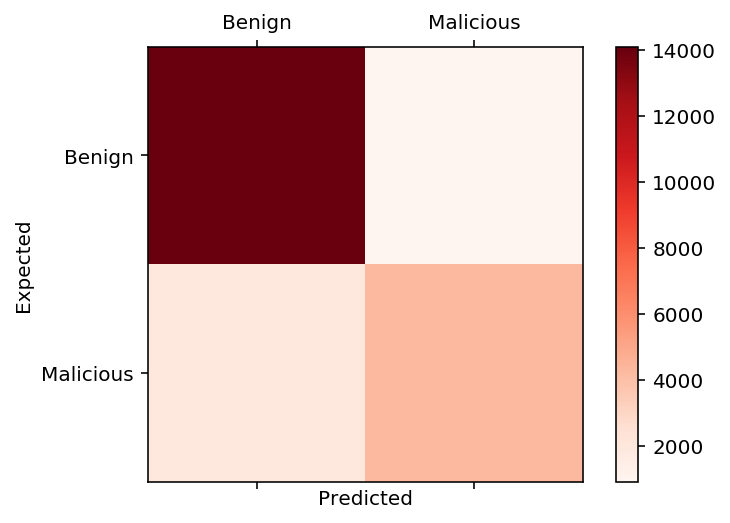

In [34]:
# Features
features = ['label', 'domain_age', 'entropy', 'suffix', 'designation', 'number_suffix', 'digits_percentage', 'specials']

# Test size
test_percentage = 0.2

# Class weight
# Options: 
# dict({0:1, 1:7})
# 'balanced'
class_weight ='balanced'

train_model(train_test_df, features, test_percentage, class_weight)

# Candidates  =  'whois', 'status', 'suffix' ,'entropy', 'designation',  'number_suffix', 'non_alphanumeric'

In [35]:
# Define features
mal_features = ['domain_age', 'entropy', 'suffix', 'designation', 'number_suffix', 'digits_percentage', 'specials']
    
# User to predict maliciousness
url = 'https://docs.microsoft.com/en-us/azure/machine-learning/team-data-science-process/lifecycle?'

# Example urls 'xiazai1.wan4399.com', 'xcl168.s37.jjisp.com'
print('Initiating Malicious URL Classifier:')

# Produce output
malURL_output = predict_maliciousness(url, mal_features)

# Display features and score
display(malURL_output[0])
print("\n\n\n [" + url + "] maliciousness score: " + malURL_output[1])

# Considerations:
# - urls with hyphens

Initiating Malicious URL Classifier:
  * Loading features
  * Number of features extracted: 19
  * New unseen value added to label encoder.


/Users/alistairgillespie/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/alistairgillespie/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,url,domain,suffix,domain_name,domain_creation,domain_age,entropy,number_suffix,number_digits,string_length,digits_percentage,specials,host_ip,prefix,designation,date,whois,rdap,status
0,https://docs.microsoft.com/en-us/azure/machine...,microsoft,172,microsoft.com,1991-05-02 04:00:00,0.815865,0.556232,0.047619,0.0,0.054622,0.0,0.033333,104.215.148.63,104,19,NaN,NaN,NaN,NaN





 [https://docs.microsoft.com/en-us/azure/machine-learning/team-data-science-process/lifecycle?] maliciousness score: 0.205198060626191
